
 # The Hospital Value-Based Purchasing (VBP) Program


## Analysis Questions

### 1) How is each Measure Type of the VBP score correlated to the Total Performance score?  Are some Measure Types driving the Total Performance Score more than others?

### 2) Does the Person and Community Engagement Measure have relationships with the other Measures on the VBP score?

### 3) How do the Measures of the VBP score behave depending on the hospital's ownership?

### 4) Which state has the best Hospital based on the VBP Total Performance Score? 

### 5) Based on the VBP Total Performance Score where are the best hospitals in the United States?

### 6) Are state-census variables like the size of Population, the Per Capita Income and the poverty influencing the Total Performance Score score of the VBP evaluated hospitals? 



In [1]:
# Import 
import warnings
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
from census import Census
import requests
import hvplot.pandas

#To ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# Import U.S. Census API Key
from config import api_key

# Create an instance of the Census library
c=Census(
    api_key,
    year = 2022
)

## Preparing, Cleaning and Merging Data

### 1) Merging Information (csv files)

### 2) Selecting Information (applicable columns)

### 3) Cleaning Information (NaN, Missing Data)ta)aa)



In [3]:
# File Path
general_data_to_load = Path("Resources/Hospital_General_Information.csv")
score_data_to_load = Path("Resources/hvbp_tps.csv")
locations_data_to_load=Path("Resources/hospital_locations.csv")

# Read Hospital General, Score, and Location Data File and store into Pandas DataFrames
general_data = pd.read_csv(general_data_to_load, encoding='latin1')
score_data = pd.read_csv(score_data_to_load)
locations_data=pd.read_csv(locations_data_to_load)

# Combine the data from the General and Score files into a single dataset
hospital_data_complete = pd.merge(general_data, score_data, how="left", left_on='Provider ID', right_on="Facility ID")

# Make an output for the new dataset
output_file_path= 'hospital_data_complete.csv'
hospital_data_complete.to_csv(output_file_path, index=False)
hospital_data_complete=pd.read_csv(output_file_path)


hospital_data_complete.head()

,Provider ID,Hospital Name,Address_x,City,State_x,ZIP Code_x,County Name,Phone Number,Hospital Type,Hospital Ownership,...,County/Parish,Unweighted Normalized Clinical Outcomes Domain Score,Weighted Normalized Clinical Outcomes Domain Score,Unweighted Person And Community Engagement Domain Score,Weighted Person And Community Engagement Domain Score,Unweighted Normalized Safety Domain Score,Weighted Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,HOUSTON,38.33333333,9.583333333,16,4,8,2,0,0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,MARSHALL,28,7,6,1.5,22,5.5,30,7.5,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,LAUDERDALE,0,0,6,1.5,48,12,0,0,13.500000
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,...,COVINGTON,6.666666667,2.222222222,24,8,Not Available,Not Available,50,16.66666667,26.888889
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Calculate the number of hospitals and find the column names
hospital_unique_count=hospital_data_complete['Hospital Name'].nunique()
print("Number of unique hospitals:",hospital_unique_count)
#print (hospital_data_complete.columns)

Number of unique hospitals: 4623


In [5]:
# Identify incomplete rows
hospital_data_complete.count()

Provider ID                                                         4812
Hospital Name                                                       4812
Address_x                                                           4812
City                                                                4812
State_x                                                             4812
ZIP Code_x                                                          4812
County Name                                                         4797
Phone Number                                                        4812
Hospital Type                                                       4812
Hospital Ownership                                                  4812
Emergency Services                                                  4812
Meets criteria for meaningful use of EHRs                           4669
Hospital overall rating                                             4812
Hospital overall rating footnote                   

In [6]:
#Make a new data frame for Hospital Information and Weighted Value Based Payment Scores

hospital_data_df = pd.DataFrame({
    'Provider ID': hospital_data_complete['Provider ID'],
    'Hospital Name': hospital_data_complete['Hospital Name'],
    'Address': hospital_data_complete['Address_x'],  # Renamed to 'Address'
    'City': hospital_data_complete['City'],
    'State': hospital_data_complete['State_x'],      # Renamed to 'State'
    'ZIP Code': hospital_data_complete['ZIP Code_x'],# Renamed to 'Zip Code'
    'County Name': hospital_data_complete['County Name'],
    'Phone Number': hospital_data_complete['Phone Number'],
    'Hospital Type': hospital_data_complete['Hospital Type'],
    'Hospital Ownership': hospital_data_complete['Hospital Ownership'],
    'Emergency Services': hospital_data_complete['Emergency Services'],
    'Meets criteria for meaningful use of EHRs': hospital_data_complete['Meets criteria for meaningful use of EHRs'],
    'Hospital overall rating': hospital_data_complete['Hospital overall rating'],
    'Weighted Normalized Clinical Outcomes Domain Score': hospital_data_complete['Weighted Normalized Clinical Outcomes Domain Score'],
    'Weighted Person And Community Engagement Domain Score': hospital_data_complete['Weighted Person And Community Engagement Domain Score'],
    'Weighted Safety Domain Score': hospital_data_complete['Weighted Safety Domain Score'],
    'Weighted Efficiency And Cost Reduction Domain Score': hospital_data_complete['Weighted Efficiency And Cost Reduction Domain Score'],
    'Total Performance Score': hospital_data_complete['Total Performance Score']
})

hospital_data_df.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Weighted Normalized Clinical Outcomes Domain Score,Weighted Person And Community Engagement Domain Score,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,9.583333333,4,2,0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,7,1.5,5.5,7.5,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,0,1.5,12,0,13.500000
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,2.222222222,8,Not Available,16.66666667,26.888889
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,Yes,Y,3,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop all rows with missing information

# First, drop rows with any NaN values
hospital_data_df = hospital_data_df.dropna(how='any')

# Then, drop rows where 'Not Available' is present in any column
hospital_data_df = hospital_data_df[~hospital_data_df.isin(['Not Available']).any(axis=1)]

columns_to_convert = ['Hospital overall rating',
                      'Weighted Normalized Clinical Outcomes Domain Score',
                      'Weighted Person And Community Engagement Domain Score',
                      'Weighted Safety Domain Score',
                      'Weighted Efficiency And Cost Reduction Domain Score']

new_hospital_data_df = hospital_data_df.copy()  # Copy the original DataFrame

for col in columns_to_convert:

    new_hospital_data_df[col] = new_hospital_data_df[col].astype(float)

# Find the data types for columns
#new_hospital_data_df.info()

new_hospital_data_df.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Weighted Normalized Clinical Outcomes Domain Score,Weighted Person And Community Engagement Domain Score,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,9.583333,4.0,2.0,0.0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,7.000000,1.5,5.5,7.5,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2.0,0.000000,1.5,12.0,0.0,13.500000
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2.0,3.750000,4.0,4.0,2.5,14.250000
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,Yes,Y,3.0,3.125000,3.5,17.5,0.0,24.125000


## Correlation Between Value Based Performance Metrics and Total Performance Score

### Question #1: How is each Measure Type of the VBP score correlated to the Total Performance score? Are some Measure Types driving the Total Performance Score more than others?

In [8]:
new_hospital_data_df[["Weighted Normalized Clinical Outcomes Domain Score", "Weighted Person And Community Engagement Domain Score","Weighted Safety Domain Score",
                      "Weighted Efficiency And Cost Reduction Domain Score","Total Performance Score"]].corr()


,Weighted Normalized Clinical Outcomes Domain Score,Weighted Person And Community Engagement Domain Score,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
Weighted Normalized Clinical Outcomes Domain Score,1.000000,0.009431,-0.112431,-0.052748,0.331402
Weighted Person And Community Engagement Domain Score,0.009431,1.000000,0.032724,0.137783,0.411771
Weighted Safety Domain Score,-0.112431,0.032724,1.000000,0.068557,0.591046
Weighted Efficiency And Cost Reduction Domain Score,-0.052748,0.137783,0.068557,1.000000,0.651048
Total Performance Score,0.331402,0.411771,0.591046,0.651048,1.000000


In [9]:
# Define a function to create Linear Regression plots
def plot_linear_regression(x_values, y_values, xlabel, ylabel, title, coordinates):
    # Perform linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

    # Get regression values
    regress_values = x_values * slope + intercept

    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Create plot
    plt.scatter(x_values, y_values, edgecolors="black", alpha=0.75)
    plt.plot(x_values, regress_values, "m-", label=line_eq)

    # Annotate the line equation on the plot
    plt.annotate(line_eq, coordinates, fontsize=15, color="red")

    #Include Title with R-Value in title
    title_with_r = f"{title}\nR = {round(rvalue, 2)}"
    
    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title_with_r)
    
    # Show legend
    plt.legend()

    # Show plot
    plt.show()



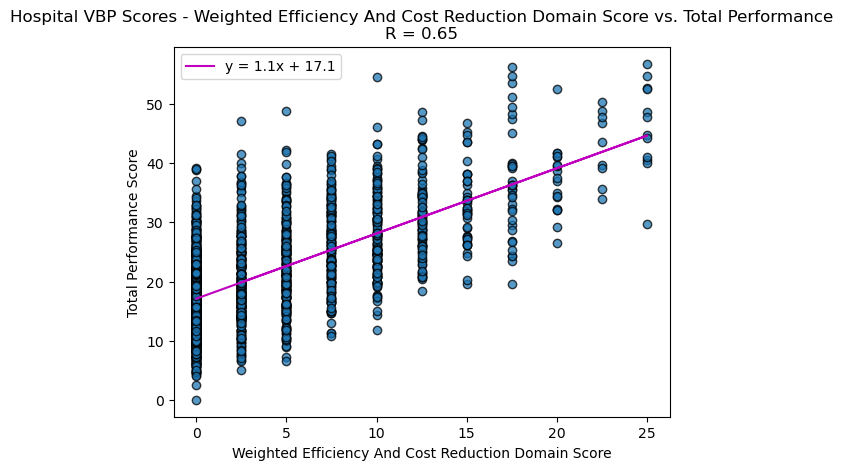

In [10]:
# Linear regression Cost and Total Performance 

plot_linear_regression(new_hospital_data_df['Weighted Efficiency And Cost Reduction Domain Score'], new_hospital_data_df['Total Performance Score'], 
                       'Weighted Efficiency And Cost Reduction Domain Score', 
                       'Total Performance Score', 
                       'Hospital VBP Scores - Weighted Efficiency And Cost Reduction Domain Score vs. Total Performance', (10, 270))


plt.show()

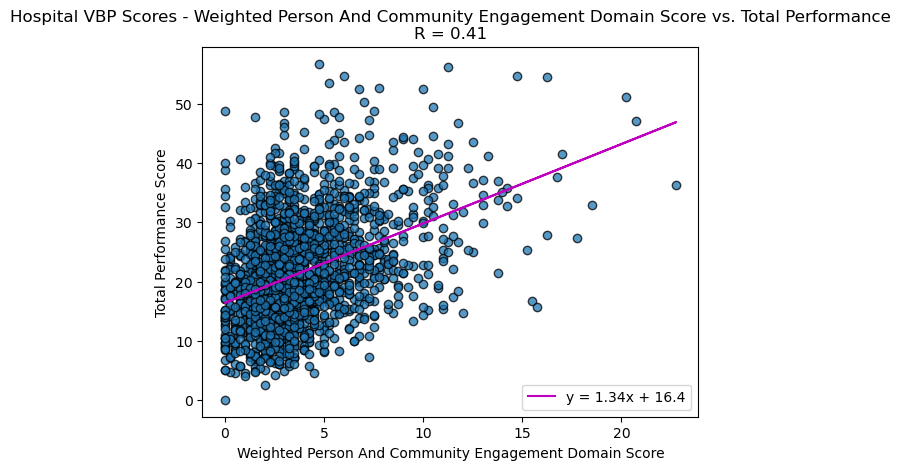

In [11]:
# Linear regression Community Engagement and Total Performance

plot_linear_regression(new_hospital_data_df['Weighted Person And Community Engagement Domain Score'], new_hospital_data_df['Total Performance Score'], 
                       'Weighted Person And Community Engagement Domain Score', 
                       'Total Performance Score', 
                       'Hospital VBP Scores - Weighted Person And Community Engagement Domain Score vs. Total Performance', (10, 270))

plt.show()

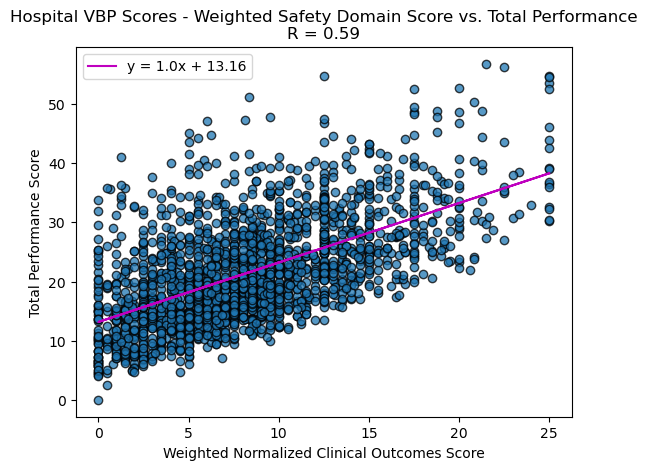

In [12]:
# Linear regression Safety and Total Performance 

plot_linear_regression(new_hospital_data_df['Weighted Safety Domain Score'], new_hospital_data_df['Total Performance Score'], 
                       'Weighted Normalized Clinical Outcomes Score', 
                       'Total Performance Score', 
                       'Hospital VBP Scores - Weighted Safety Domain Score vs. Total Performance', (10, 270))

plt.show()

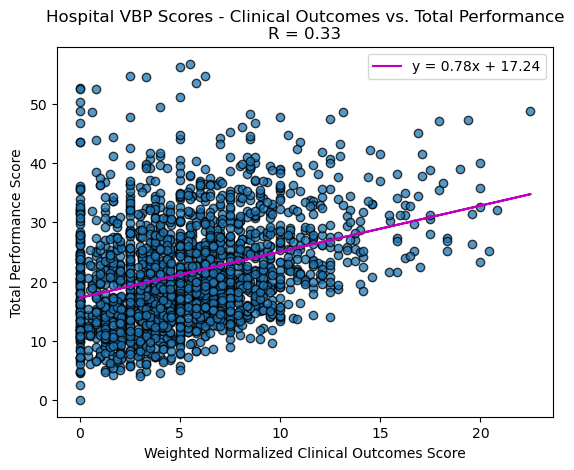

In [13]:
# Linear regression Clinical Outcomes and Total Performance

plot_linear_regression(new_hospital_data_df['Weighted Normalized Clinical Outcomes Domain Score'], new_hospital_data_df['Total Performance Score'], 
                       'Weighted Normalized Clinical Outcomes Score', 
                       'Total Performance Score', 
                       'Hospital VBP Scores - Clinical Outcomes vs. Total Performance', (10, 270))

plt.show()

## Correlation Between Person Engagement and Other Metrics

### Question #2: Is the Person and Community Engagement Measure have relationships with the other Measures on the VBP score?

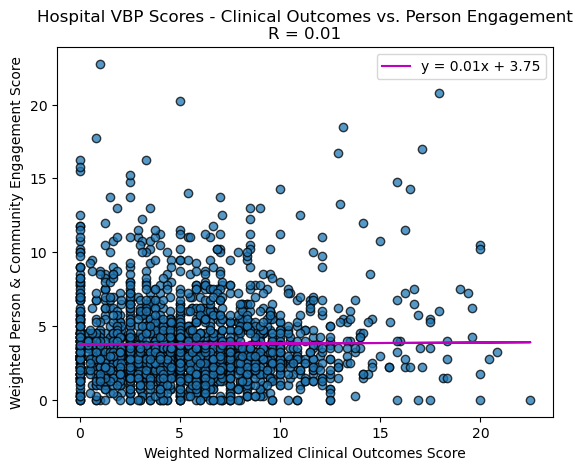

In [14]:
# Linear regression Clinical Outcomes and Person Enagagement

plot_linear_regression(new_hospital_data_df['Weighted Normalized Clinical Outcomes Domain Score'], new_hospital_data_df['Weighted Person And Community Engagement Domain Score'], 
                       'Weighted Normalized Clinical Outcomes Score', 
                       'Weighted Person & Community Engagement Score', 
                       'Hospital VBP Scores - Clinical Outcomes vs. Person Engagement', (10, 270))

plt.show()

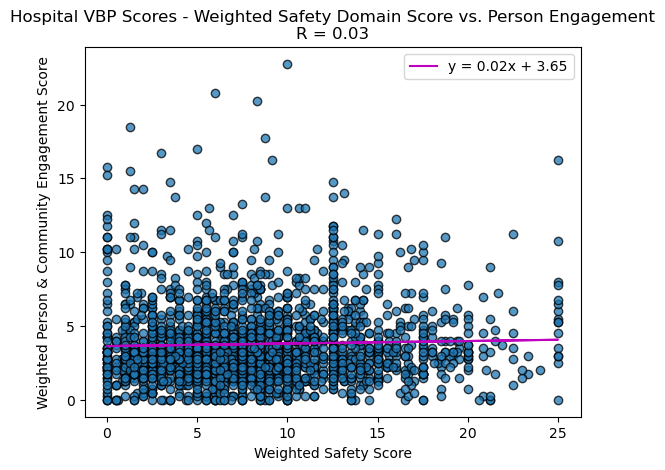

In [15]:
# Safety and Person Engagement
plot_linear_regression(new_hospital_data_df['Weighted Safety Domain Score'], new_hospital_data_df['Weighted Person And Community Engagement Domain Score'], 
                       'Weighted Safety Score', 
                       'Weighted Person & Community Engagement Score', 
                       'Hospital VBP Scores - Weighted Safety Domain Score vs. Person Engagement', (10, 270))

plt.show()

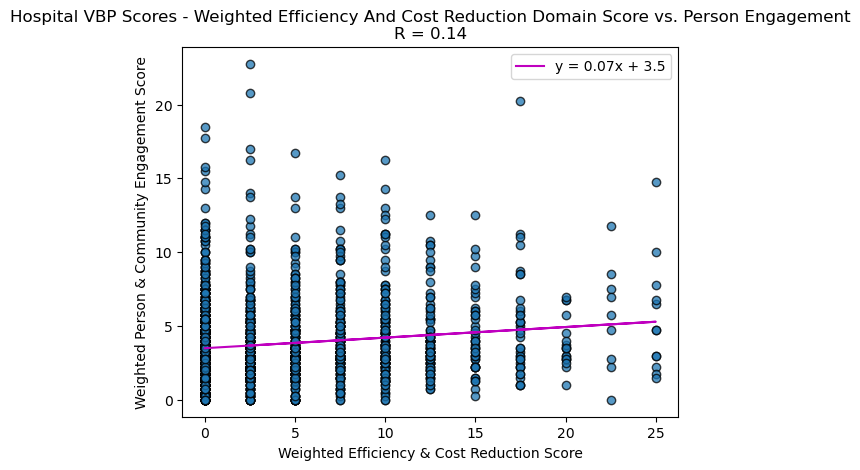

In [16]:
# Cost Reduction and Person Engagement
plot_linear_regression(new_hospital_data_df['Weighted Efficiency And Cost Reduction Domain Score'], new_hospital_data_df['Weighted Person And Community Engagement Domain Score'], 
                       'Weighted Efficiency & Cost Reduction Score', 
                       'Weighted Person & Community Engagement Score', 
                       'Hospital VBP Scores - Weighted Efficiency And Cost Reduction Domain Score vs. Person Engagement', (10, 270))

plt.show()

### Result for Question #1 & #2: It seems that Efficiency and Cost Reduction Measure has the closest correlation with the Total Performance Score.  There does not seem to be a correlation relationship between any of the measures and the Person Engagement Measure. 

## Using the Unweighted Values

In [17]:
# Create a data frame with Hosptial General Information and Unweighted Value Based Payment Scores 

hospital_unweighted = pd.DataFrame({
    'Provider ID': hospital_data_complete['Provider ID'],
    'Hospital Name': hospital_data_complete['Hospital Name'],
    'Address': hospital_data_complete['Address_x'],  # Renamed to 'Address'
    'City': hospital_data_complete['City'],
    'State': hospital_data_complete['State_x'],      # Renamed to 'State'
    'ZIP Code': hospital_data_complete['ZIP Code_x'],# Renamed to 'Zip Code'
    'County Name': hospital_data_complete['County Name'],
    'Phone Number': hospital_data_complete['Phone Number'],
    'Hospital Type': hospital_data_complete['Hospital Type'],
    'Hospital Ownership': hospital_data_complete['Hospital Ownership'],
    'Emergency Services': hospital_data_complete['Emergency Services'],
    'Meets criteria for meaningful use of EHRs': hospital_data_complete['Meets criteria for meaningful use of EHRs'],
    'Hospital overall rating': hospital_data_complete['Hospital overall rating'],
    'Unweighted Normalized Clinical Outcomes Domain Score': hospital_data_complete['Unweighted Normalized Clinical Outcomes Domain Score'],
    'Unweighted Person And Community Engagement Domain Score': hospital_data_complete['Unweighted Person And Community Engagement Domain Score'],
    'Unweighted Normalized Safety Domain Score': hospital_data_complete['Unweighted Normalized Safety Domain Score'],
    'Unweighted Normalized Efficiency And Cost Reduction Domain Score': hospital_data_complete['Unweighted Normalized Efficiency And Cost Reduction Domain Score'],
    'Total Performance Score': hospital_data_complete['Total Performance Score']
})

hospital_unweighted.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Unweighted Normalized Clinical Outcomes Domain Score,Unweighted Person And Community Engagement Domain Score,Unweighted Normalized Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,38.33333333,16,8,0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,28,6,22,30,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,0,6,48,0,13.500000
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,6.666666667,24,Not Available,50,26.888889
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,Yes,Y,3,NaN,NaN,NaN,NaN,NaN


In [18]:
# First, drop rows with any NaN values
hospital_unweighted = hospital_unweighted.dropna(how='any')

# Then, drop rows where 'Not Available' is present in any column
hospital_unweighted = hospital_unweighted[~hospital_unweighted.isin(['Not Available']).any(axis=1)]

columns_to_convert = ['Hospital overall rating',
                      'Unweighted Normalized Clinical Outcomes Domain Score',
                      'Unweighted Person And Community Engagement Domain Score',
                      'Unweighted Normalized Safety Domain Score',
                      'Unweighted Normalized Efficiency And Cost Reduction Domain Score']

new_hospital_unweighted = hospital_unweighted.copy()  # Copy the original DataFrame

for col in columns_to_convert:

    new_hospital_unweighted[col] = new_hospital_unweighted[col].astype(float)


new_hospital_unweighted.head()


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Unweighted Normalized Clinical Outcomes Domain Score,Unweighted Person And Community Engagement Domain Score,Unweighted Normalized Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,38.333333,16.0,8.0,0.0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,28.000000,6.0,22.0,30.0,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2.0,0.000000,6.0,48.0,0.0,13.500000
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2.0,15.000000,16.0,16.0,10.0,14.250000
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,Yes,Y,3.0,12.500000,14.0,70.0,0.0,24.125000


In [19]:
new_hospital_unweighted[["Unweighted Normalized Clinical Outcomes Domain Score", "Unweighted Person And Community Engagement Domain Score","Unweighted Normalized Safety Domain Score",
                      "Unweighted Normalized Efficiency And Cost Reduction Domain Score","Total Performance Score"]].corr()

,Unweighted Normalized Clinical Outcomes Domain Score,Unweighted Person And Community Engagement Domain Score,Unweighted Normalized Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Total Performance Score
Unweighted Normalized Clinical Outcomes Domain Score,1.000000,0.009431,-0.112431,-0.052748,0.331402
Unweighted Person And Community Engagement Domain Score,0.009431,1.000000,0.032724,0.137783,0.411771
Unweighted Normalized Safety Domain Score,-0.112431,0.032724,1.000000,0.068557,0.591046
Unweighted Normalized Efficiency And Cost Reduction Domain Score,-0.052748,0.137783,0.068557,1.000000,0.651048
Total Performance Score,0.331402,0.411771,0.591046,0.651048,1.000000


## Analysis by Hospital Ownership Type

### Question #3: How do the Measures of the VBP score behave depending on the hospital's ownership?

In [20]:
#Finding the Totals of Hospital Types
print(new_hospital_data_df['Hospital Ownership'].value_counts())

Hospital Ownership
Voluntary non-profit - Private                 962
Proprietary                                    371
Voluntary non-profit - Other                   214
Voluntary non-profit - Church                  205
Government - Hospital District or Authority    138
Government - Local                              82
Government - State                              33
Government - Federal                             6
Physician                                        6
Name: count, dtype: int64


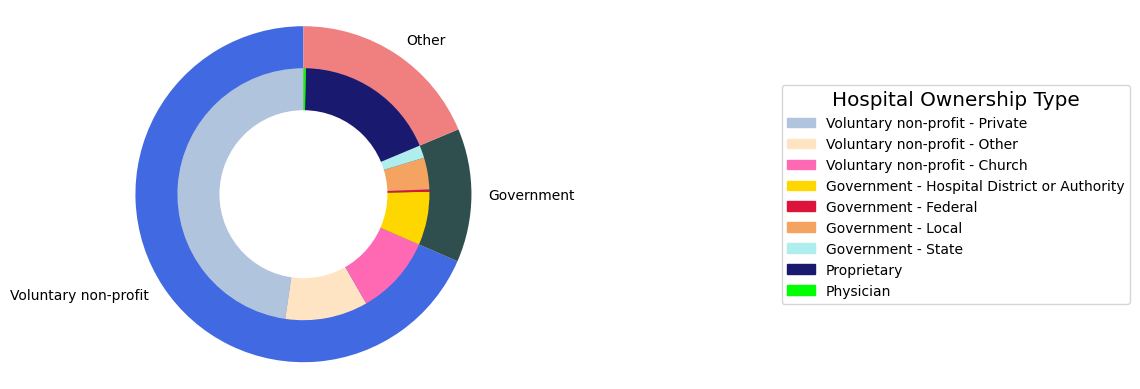

In [21]:
#Creating a Pie Chart for Hospital Types
# Data to plot
labels = ['Voluntary non-profit', 'Government', 'Other']
sizes = [1381, 259, 377]
labels_ownership = ['Voluntary non-profit - Private', 'Voluntary non-profit - Other','Voluntary non-profit - Church',
                         'Government - Hospital District or Authority','Government - Federal','Government - Local','Government - State','Proprietary','Physician']
sizes_ownership = [962, 214, 205, 138, 6, 82, 33, 371, 6]
colors = ['royalblue', 'darkslategray', 'lightcoral']
colors_ownership = ['lightsteelblue', 'bisque', 'hotpink', 'gold', 'crimson', 'sandybrown', 'paleturquoise', 'midnightblue', 'lime']

# Plot
fig, ax = plt.subplots()
wedges, _ = ax.pie(sizes, labels=labels, colors=colors, startangle=90, frame=True)
wedges_ownership, _ = ax.pie(sizes_ownership, colors=colors_ownership, radius=0.75, startangle=90)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig.gca().add_artist(centre_circle)

# Custom legend
legend_labels = labels_ownership
legend_colors = colors_ownership
legend = ax.legend(legend_labels, loc="center left", bbox_to_anchor=(1.45, 0.5), title='Hospital Ownership Type', title_fontsize='medium')

# Set legend colors to match chart colors
for handle, color in zip(legend.legendHandles, legend_colors):
    handle.set_color(color)

# Title on top of the legend
legend_title = legend.get_title()
legend_title.set_fontsize('x-large')

plt.axis('equal')
plt.tight_layout()
plt.show()

In [22]:
#Finding the average scores for each category for each Type of Hospital Ownership

performance_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')["Total Performance Score"].mean()
clinical_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')['Weighted Normalized Clinical Outcomes Domain Score'].mean()
person_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')["Weighted Person And Community Engagement Domain Score"].mean()
safety_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')["Weighted Safety Domain Score"].mean()
efficiency_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')["Weighted Efficiency And Cost Reduction Domain Score"].mean()

hospital_by_ownership=pd.DataFrame({'Weighted Normalized Clinical Outcomes Domain Score Avg':clinical_ownership_mean,
                          'Weighted Person And Community Engagement Domain Score Avg':person_ownership_mean, 'Weighted Safety Domain Score Avg':safety_ownership_mean,
                          'Weighted Efficiency And Cost Reduction Domain Score Avg':efficiency_ownership_mean, 
                          'Total Performance Score Avg':performance_ownership_mean})

hospital_by_ownership= hospital_by_ownership.sort_values(["Total Performance Score Avg"], ascending=False)
hospital_by_ownership

,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
Hospital Ownership,,,,,
Government - Federal,5.305556,3.333333,8.736111,9.583333,26.958333
Voluntary non-profit - Other,5.827687,3.837617,8.208917,4.988318,22.862539
Physician,3.020833,6.833333,11.020833,1.666667,22.541667
Voluntary non-profit - Private,5.713401,3.967775,7.891026,4.132017,21.704219
Voluntary non-profit - Church,5.489024,3.759756,7.968902,4.121951,21.339634
Proprietary,5.272350,2.994609,9.787848,2.823450,20.878257
Government - Hospital District or Authority,4.135568,4.311594,8.331522,3.876812,20.655495
Government - Local,3.939024,3.923780,7.754573,4.390244,20.007622
Government - State,6.060606,4.325758,5.295455,3.560606,19.242424


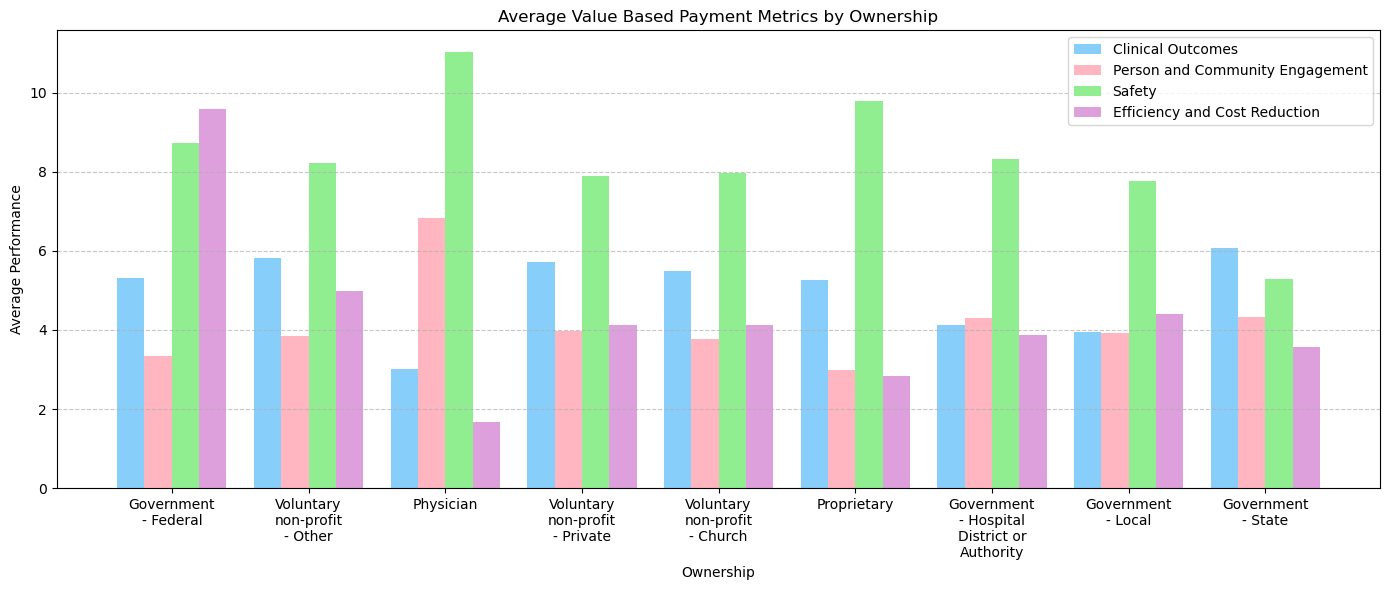

In [23]:
#Comparing Hospital Scores by Hsoptial Ownership Types
bar_width = 0.20

# Center positions for each group of bars
x = range(len(hospital_by_ownership))

# Plotting
plt.figure(figsize=(14, 6))

# Plot the first set of bars
plt.bar([i - 1.5 * bar_width for i in x], hospital_by_ownership['Weighted Normalized Clinical Outcomes Domain Score Avg'], width=bar_width, color='lightskyblue', label='Clinical Outcomes')

# Plot the second set of bars next to the first one
plt.bar([i - 0.5 * bar_width for i in x], hospital_by_ownership['Weighted Person And Community Engagement Domain Score Avg'], width=bar_width, color='lightpink', label='Person and Community Engagement')

# Plot the third set of bars next to the second one
plt.bar([i + 0.5 * bar_width for i in x], hospital_by_ownership['Weighted Safety Domain Score Avg'], width=bar_width, color='lightgreen', label='Safety')

# Plot the fourth set of bars next to the third one
plt.bar([i + 1.5 * bar_width for i in x], hospital_by_ownership['Weighted Efficiency And Cost Reduction Domain Score Avg'], width=bar_width, color='plum', label='Efficiency and Cost Reduction')

from textwrap import wrap

# Custom tick label formatter to wrap the labels
def wrap_labels(labels, width=11):
    wrapped_labels = ['\n'.join(wrap(label, width)) for label in labels]
    return wrapped_labels

# Assuming x is defined as the center positions for each group of bars

# Wrapping tick labels
wrapped_labels = wrap_labels(hospital_by_ownership.index, width=11)
plt.xticks(x, wrapped_labels)

plt.title('Average Value Based Payment Metrics by Ownership')
plt.xlabel('Ownership')
plt.ylabel('Average Performance')
#plt.xticks([i for i in x], hospital_by_ownership.index, rotation=80)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

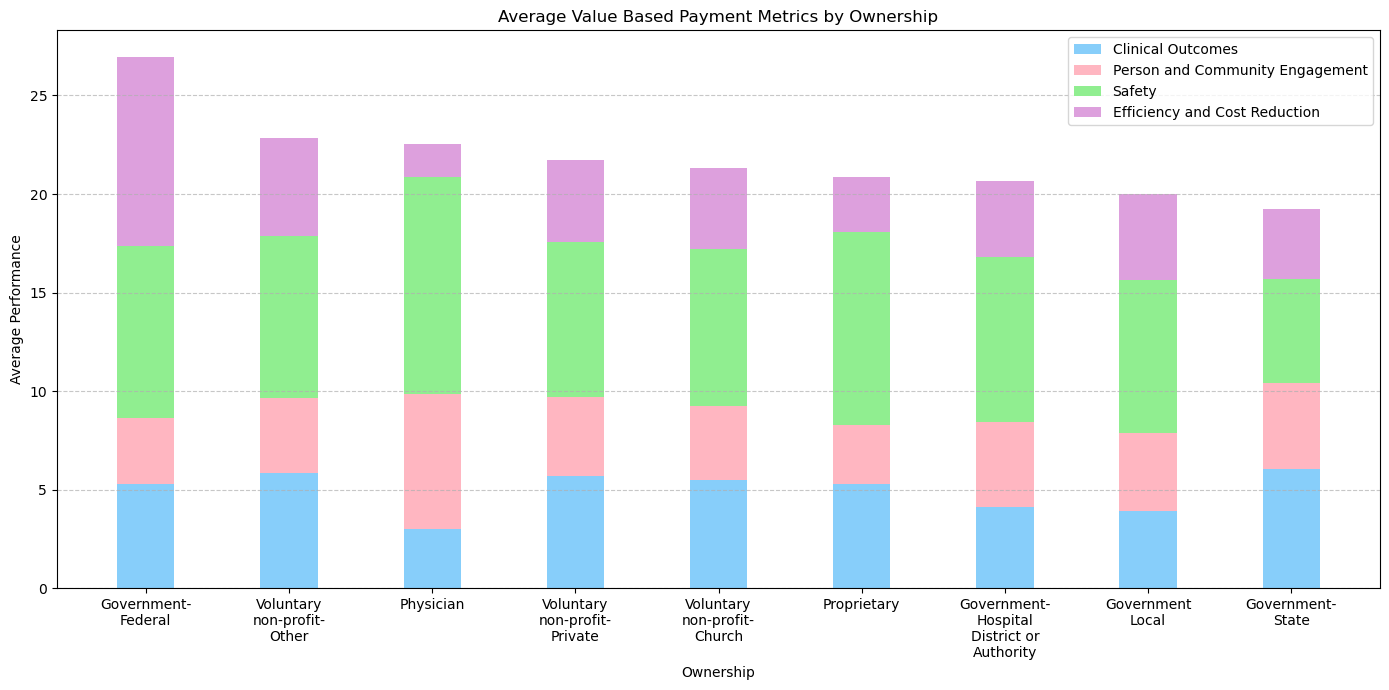

In [24]:
import numpy as np
#Create stacked bar groph to show the contribution of each average of score type to whole
hospital_by_ownership = {
    'Weighted Normalized Clinical Outcomes Domain Score Avg': [5.305556, 4.135568, 3.939024, 6.060606, 3.020833, 5.272350, 5.489024, 5.827687, 5.713401],
    'Weighted Person And Community Engagement Domain Score Avg': [3.333333, 4.311594, 3.923780, 4.325758, 6.833333, 2.994609, 3.759756, 3.837617, 3.967775],
    'Weighted Safety Domain Score Avg': [8.736111, 8.331522, 7.754573, 5.295455, 11.020833, 9.787848, 7.968902, 8.208917, 7.891026],
    'Weighted Efficiency And Cost Reduction Domain Score Avg': [9.583333, 3.876812, 4.390244, 3.560606, 1.666667, 2.823450, 4.121951, 4.988318, 4.132017]
}
ownership_labels = ['Government-Federal', 'Government- Hospital District or Authority', 'Government Local', 'Government- State', 
                    'Physician', 'Proprietary', 'Voluntary non-profit-Church', 'Voluntary non-profit- Other', 'Voluntary non-profit-Private']

# Convert the dictionary to a format suitable for plotting
data = np.array([hospital_by_ownership[key] for key in hospital_by_ownership]).T

# Calculate the total score for each ownership category
total_scores = np.sum(data, axis=1)

# Sort the data by total score in descending order
sorted_indices = np.argsort(total_scores)[::-1]
sorted_data = data[sorted_indices]
sorted_ownership_labels = [ownership_labels[i] for i in sorted_indices]

bar_width = 0.40
x = np.arange(len(sorted_ownership_labels))

# Plotting
plt.figure(figsize=(14, 7))

# Plot the stacked bars
plt.bar(x, sorted_data[:, 0], width=bar_width, color='lightskyblue', label='Clinical Outcomes')
plt.bar(x, sorted_data[:, 1], width=bar_width, color='lightpink', bottom=sorted_data[:, 0], label='Person and Community Engagement')
plt.bar(x, sorted_data[:, 2], width=bar_width, color='lightgreen', bottom=sorted_data[:, 0] + sorted_data[:, 1], label='Safety')
plt.bar(x, sorted_data[:, 3], width=bar_width, color='plum', bottom=sorted_data[:, 0] + sorted_data[:, 1] + sorted_data[:, 2], label='Efficiency and Cost Reduction')

# Custom tick label formatter to wrap the labels
def wrap_labels(labels, width=11):
    wrapped_labels = ['\n'.join(wrap(label, width)) for label in labels]
    return wrapped_labels

# Wrapping tick labels
wrapped_labels = wrap_labels(sorted_ownership_labels, width=11)
plt.xticks(x, wrapped_labels)

plt.title('Average Value Based Payment Metrics by Ownership')
plt.xlabel('Ownership')
plt.ylabel('Average Performance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### Result for Question #3: Government-Federal Scored the Highest, but only had 6 hospitals innvolved in VBP Measures.  Voluntary- Non-Profit- Other was the second highest scoring hospital ownership type and also had the most amount of hospitals involved in VBP.  Physician owned hospitals scored highest in Safety and Government- Federal scored highest in Efficiency and Cost Reduction.  However, these were also categories with the least amount of hospitals in VBP.  

## Analysis of Value Based Performance and State

### Question #4:  Which state has the best Hospital based on the VBP Total Performance Score?

In [25]:
#Find Counts of Weighted Scores by State

rating_by_state_count = new_hospital_data_df.groupby('State')['Hospital overall rating'].count()
clinical_by_state_count = new_hospital_data_df.groupby('State')['Weighted Normalized Clinical Outcomes Domain Score'].count()
person_score_by_state_count = new_hospital_data_df.groupby('State')['Weighted Person And Community Engagement Domain Score'].count()
safety_by_state_count = new_hospital_data_df.groupby('State')['Weighted Safety Domain Score'].count()
efficiency_by_state_count = new_hospital_data_df.groupby('State')['Weighted Efficiency And Cost Reduction Domain Score'].count()
performance_total_by_state_count = new_hospital_data_df.groupby('State')['Total Performance Score'].count()

by_state_df_count=pd.DataFrame({'Hospital Rate Count':rating_by_state_count,'Weighted Normalized Clinical Outcomes Domain Score Count':clinical_by_state_count,
                          'Weighted Person And Community Engagement Domain Score Count':person_score_by_state_count, 'Weighted Safety Domain Score Count':safety_by_state_count,
                          'Weighted Efficiency And Cost Reduction Domain Score Count':efficiency_by_state_count, 
                          'Total Performance Score Count':performance_total_by_state_count})

by_state_df_count.head()

,Hospital Rate Count,Weighted Normalized Clinical Outcomes Domain Score Count,Weighted Person And Community Engagement Domain Score Count,Weighted Safety Domain Score Count,Weighted Efficiency And Cost Reduction Domain Score Count,Total Performance Score Count
State,,,,,,
AK,5,5,5,5,5,5
AL,39,39,39,39,39,39
AR,23,23,23,23,23,23
AZ,41,41,41,41,41,41
CA,194,194,194,194,194,194


In [26]:
#Find Avergages of Weighted Scores by State
rating_by_state = new_hospital_data_df.groupby('State')['Hospital overall rating'].mean()
clinical_by_state = new_hospital_data_df.groupby('State')['Weighted Normalized Clinical Outcomes Domain Score'].mean()
person_score_by_state = new_hospital_data_df.groupby('State')['Weighted Person And Community Engagement Domain Score'].mean()
safety_by_state = new_hospital_data_df.groupby('State')['Weighted Safety Domain Score'].mean()
efficiency_by_state = new_hospital_data_df.groupby('State')['Weighted Efficiency And Cost Reduction Domain Score'].mean()
performance_total_by_state = new_hospital_data_df.groupby('State')['Total Performance Score'].mean()

by_state_df=pd.DataFrame({'Hospital Rate Average':rating_by_state,'Weighted Normalized Clinical Outcomes Domain Score Avg':clinical_by_state,
                          'Weighted Person And Community Engagement Domain Score Avg':person_score_by_state, 'Weighted Safety Domain Score Avg':safety_by_state,
                          'Weighted Efficiency And Cost Reduction Domain Score Avg':efficiency_by_state, 
                          'Total Performance Score Avg':performance_total_by_state})

by_state_df.head()

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
AK,2.800000,4.450000,4.650000,11.566667,17.500000,38.166667
AL,2.820513,3.475427,4.525641,8.787393,4.166667,20.955128
AR,2.521739,4.961957,3.358696,9.181159,0.108696,17.610507
AZ,2.975610,5.130081,2.530488,7.914634,4.024390,19.599593
CA,2.840206,6.242698,2.746134,8.344287,4.072165,21.405284


In [27]:
# Sort the states by average Total Performance Score in descending order and display the top 10 rows.
top_states =by_state_df.sort_values(["Total Performance Score Avg"], ascending=False) 
top_states.head(10)

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
AK,2.800000,4.450000,4.650000,11.566667,17.500000,38.166667
OR,2.916667,5.357639,4.375000,7.409722,15.312500,32.454861
MN,3.541667,8.625000,5.677083,5.906250,10.729167,30.937500
WI,3.581395,5.188953,5.755814,8.385659,9.011628,28.342054
MT,3.714286,5.642857,4.321429,10.053571,8.214286,28.232143
RI,3.500000,5.619792,5.968750,9.942708,5.937500,27.468750
WA,2.947368,5.677632,2.888158,7.323465,10.526316,26.415570
SD,3.800000,6.850000,5.000000,10.975000,3.500000,26.325000
HI,3.555556,4.347222,4.222222,5.777778,10.833333,25.180556


In [28]:
# Sort the states by average Total Performance Score in ascending order and display the top 10 rows.
lowest_states =by_state_df.sort_values(["Total Performance Score Avg"], ascending=True) 
lowest_states.head(10)

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
WV,2.666667,3.199074,3.013889,5.930556,2.222222,14.365741
NM,2.416667,3.479167,2.229167,5.784722,4.791667,16.284722
DE,3.600000,5.050000,2.800000,8.700000,0.000000,16.550000
NJ,2.542373,5.461158,2.529661,8.007768,0.762712,16.761299
IN,3.607843,4.160131,4.676471,7.036765,1.372549,17.245915
AR,2.521739,4.961957,3.358696,9.181159,0.108696,17.610507
LA,3.050000,3.165625,6.437500,7.906250,0.437500,17.946875
SC,3.243243,3.670045,4.722973,8.623874,1.081081,18.097973
NV,2.058824,6.284314,1.941176,8.014706,2.058824,18.299020


## Comparison of Total Score by State and Total Count of Hospitals Scored

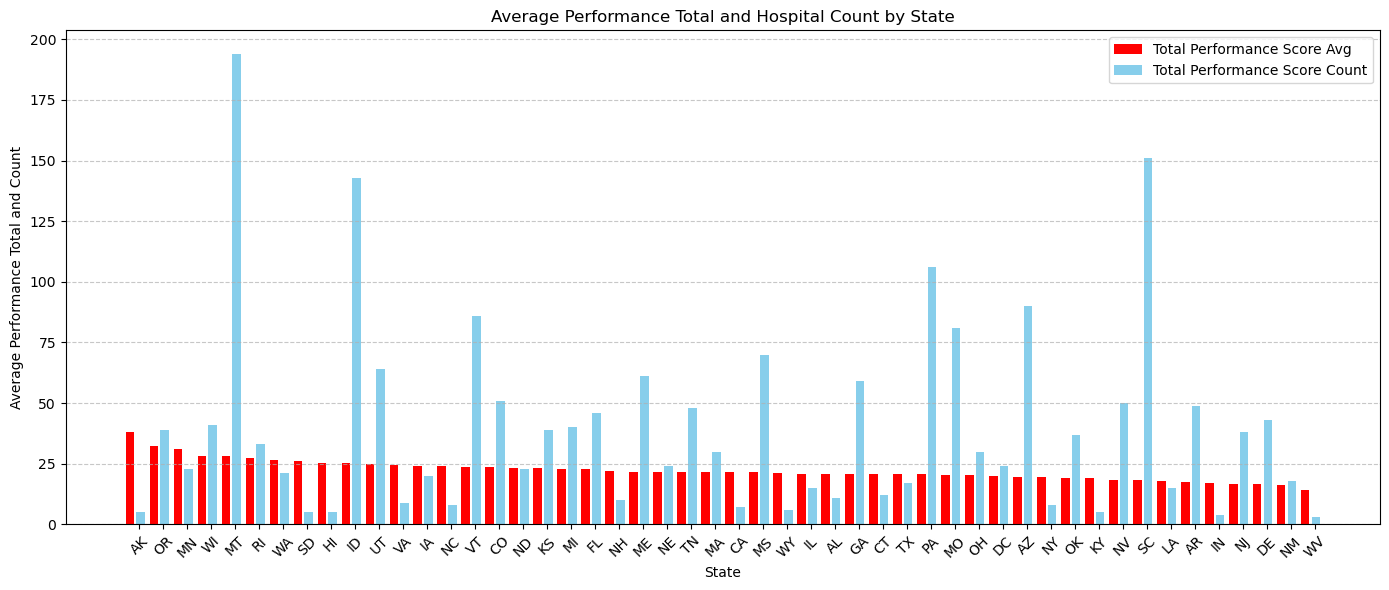

In [29]:
#Creating a Bar Chart with the Hospital Count in each state and the Total Performance Averages for Each State

bar_width = 0.35

# Center positions for each group of bars
x = range(len(top_states.index))

# Plotting
plt.figure(figsize=(14, 6))

# Plot the first set of bars
plt.bar(x, top_states['Total Performance Score Avg'], width=bar_width, color='red', label='Total Performance Score Avg')

# Plot the second set of bars next to the first one
plt.bar([i + bar_width + 0.1 for i in x], by_state_df_count['Total Performance Score Count'], width=bar_width, color='skyblue', label='Total Performance Score Count')

plt.title('Average Performance Total and Hospital Count by State')
plt.xlabel('State')
plt.ylabel('Average Performance Total and Count')
plt.xticks([i + bar_width + 0.05 for i in x], top_states.index, rotation=45)  # Adjust tick mark positions
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### Result for Question #4: Alaska Hospitals had the Highest Average Total Performance Score, but only had 4 hospitals innvolved in VBP Measures.  Montana had the most participating hospitals and also one of the highest Average Total Performance Scores.  West Virgina had some of the fewest hospitals participating and also lowest Total Performance Score.

## Comparison of Census Data and Hospital Value Based Payment Measures 

### Question #5: Based on the VBP Total Performance Score where are the best hospitals in the United States?

In [30]:
#Obtianing Census Data API informaiton and adding to a data frame
census_data = c.acs5.get(
    (
        "NAME",
        "B19013_001E",
        "B01003_001E",
        "B01002_001E",
        "B19301_001E",
        "B17001_002E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column renaming
census_pd = census_pd.rename(
    columns = {
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income",
        "B19301_001E": "Per Capita Income",
        "B17001_002E": "Poverty Count",
        "NAME": "Name",
        "zip code tabulation area": "Zipcode"
    }
)

# Add a Poverty Rate column (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

# Configure the final DataFrame
census_pd = census_pd[
    [
        "Zipcode",
        "Population",
        "Median Age",
        "Household Income",
        "Per Capita Income",
        "Poverty Count",
        "Poverty Rate"
    ]
]

census_pd['Zipcode'] = census_pd['Zipcode'].astype(int)
# Display DataFrame length and sample data
print(f"Number of rows in the DataFrame: {len(census_pd)}")
census_pd.head()

Number of rows in the DataFrame: 33774


,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,601,16834.0,44.0,17526.0,9012.0,10440.0,62.017346
1,602,37642.0,45.2,20260.0,11379.0,17768.0,47.202593
2,603,49075.0,45.0,17703.0,13010.0,23551.0,47.989812
3,606,5590.0,46.2,19603.0,9274.0,3021.0,54.042934
4,610,25542.0,44.4,22796.0,12726.0,11597.0,45.403649


In [31]:
#Merging Hospital Data Frame information with the Census Data Frame to analyze relationships
hospital_census_df=pd.merge(new_hospital_data_df, census_pd, how="left", left_on='ZIP Code', right_on="Zipcode")

hospital_census_df.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,2.0,0.0,15.583333,36301.0,38101.0,39.4,47414.0,28880.0,8279.0,21.729088
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,5.5,7.5,21.500000,35957.0,16269.0,36.4,46799.0,23239.0,3174.0,19.509497
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,12.0,0.0,13.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,...,4.0,2.5,14.250000,35235.0,20043.0,37.5,59476.0,31057.0,3836.0,19.138851
4,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,17.5,0.0,24.125000,35968.0,4870.0,39.6,54766.0,23024.0,835.0,17.145791


## Cleaning the Census and Hospital Merged Data

In [32]:
#hospital_census_df.count()

In [33]:
# First, drop rows with any NaN values
hospital_census_df = hospital_census_df.dropna(how='any')

hospital_census_df.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,2.0,0.0,15.583333,36301.0,38101.0,39.4,47414.0,28880.0,8279.0,21.729088
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,5.5,7.5,21.500000,35957.0,16269.0,36.4,46799.0,23239.0,3174.0,19.509497
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,...,4.0,2.5,14.250000,35235.0,20043.0,37.5,59476.0,31057.0,3836.0,19.138851
4,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,17.5,0.0,24.125000,35968.0,4870.0,39.6,54766.0,23024.0,835.0,17.145791
5,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,Acute Care Hospitals,Voluntary non-profit - Private,...,8.5,0.0,17.333333,35007.0,27052.0,39.7,81351.0,37693.0,1778.0,6.572527


In [34]:
# Sort the hosptials by highest performance
top_hospitals =hospital_census_df.sort_values(["Total Performance Score"], ascending=False) 
top_hospitals.head(10)


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
1496,380050,SKY LAKES MEDICAL CENTER,2865 DAGGETT AVENUE,KLAMATH FALLS,OR,97601,KLAMATH,5412746150,Acute Care Hospitals,Voluntary non-profit - Private,...,21.500000,25.0,56.750000,97601.0,22302.0,40.2,52951.0,31435.0,4498.0,20.168595
925,230072,HOLLAND COMMUNITY HOSPITAL,602 MICHIGAN AVE,HOLLAND,MI,49423,OTTAWA,6163925141,Acute Care Hospitals,Voluntary non-profit - Private,...,22.500000,17.5,56.250000,49423.0,46467.0,35.2,75164.0,35952.0,4000.0,8.608260
1018,250167,METHODIST HEALTHCARE - OLIVE BRANCH HOSPITAL,4250 BETHEL ROAD,OLIVE BRANCH,MS,38654,DESOTO,6629329000,Acute Care Hospitals,Voluntary non-profit - Private,...,25.000000,17.5,54.750000,38654.0,56449.0,38.8,96145.0,40702.0,2939.0,5.206470
960,230259,ST JOSEPH MERCY CHELSEA,775 S MAIN ST,CHELSEA,MI,48118,WASHTENAW,7344753911,Acute Care Hospitals,Voluntary non-profit - Private,...,12.500000,25.0,54.750000,48118.0,13001.0,49.1,89125.0,54661.0,355.0,2.730559
1777,450604,HILL COUNTRY MEMORIAL HOSPITAL INC,1020 SOUTH STATE HIGHWAY 16,FREDERICKSBURG,TX,78624,GILLESPIE,8309974353,Acute Care Hospitals,Voluntary non-profit - Private,...,25.000000,10.0,54.583333,78624.0,23538.0,49.8,71082.0,43152.0,1910.0,8.114538
587,130014,WEST VALLEY MEDICAL CENTER,1717 ARLINGTON STREET,CALDWELL,ID,83605,CANYON,2084594641,Acute Care Hospitals,Proprietary,...,25.000000,17.5,53.583333,83605.0,39636.0,31.5,58952.0,22059.0,5545.0,13.989807
40,20006,MAT-SU REGIONAL MEDICAL CENTER,2500 SOUTH WOODWORTH LOOP,PALMER,AK,99645,MATANUSKA SUSITNA,9078616000,Acute Care Hospitals,Voluntary non-profit - Private,...,20.000000,25.0,52.750000,99645.0,30849.0,35.8,93242.0,40987.0,2324.0,7.533469
1951,520002,MINISTRY ST MICHAELS HOSPITAL OF STEVENS POINT,900 ILLINOIS AVE,STEVENS POINT,WI,54481,PORTAGE,7153465000,Acute Care Hospitals,Voluntary non-profit - Church,...,25.000000,20.0,52.583333,54481.0,27544.0,30.7,55922.0,31552.0,3791.0,13.763433
928,230081,MUNSON HEALTHCARE CADILLAC HOSPITAL,400 HOBART ST,CADILLAC,MI,49601,WEXFORD,2318767200,Acute Care Hospitals,Voluntary non-profit - Church,...,17.500000,25.0,52.500000,49601.0,22300.0,43.1,61186.0,31643.0,2848.0,12.771300
1491,380022,SAMARITAN ALBANY GENERAL HOSPITAL,1046 6TH AVENUE SW,ALBANY,OR,97321,LINN,5418124000,Acute Care Hospitals,Voluntary non-profit - Church,...,8.333333,17.5,51.083333,97321.0,29970.0,40.6,93617.0,41274.0,2321.0,7.744411


In [35]:
# Create a DataFrame with the 25 highest performance scores
top_twenty_five_df=hospital_census_df.loc[hospital_census_df["Total Performance Score"] >45]
# Display sample data
top_twenty_five_df.head()


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
33,10130,ST VINCENT'S ST CLAIR,7063 VETERANS PARKWAY,PELL CITY,AL,35125,SAINT CLAIR,2053383301,Acute Care Hospitals,Voluntary non-profit - Private,...,12.50,22.5,46.750000,35125.0,10759.0,36.5,61865.0,29082.0,1297.0,12.055024
40,20006,MAT-SU REGIONAL MEDICAL CENTER,2500 SOUTH WOODWORTH LOOP,PALMER,AK,99645,MATANUSKA SUSITNA,9078616000,Acute Care Hospitals,Voluntary non-profit - Private,...,20.00,25.0,52.750000,99645.0,30849.0,35.8,93242.0,40987.0,2324.0,7.533469
74,30103,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,MARICOPA,4803424201,Acute Care Hospitals,Voluntary non-profit - Private,...,6.00,2.5,47.166667,85054.0,8394.0,37.8,85656.0,63847.0,1148.0,13.676436
162,50135,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,6245 DE LONGPRE AVE,HOLLYWOOD,CA,90028,LOS ANGELES,3234622271,Acute Care Hospitals,Proprietary,...,21.25,5.0,48.750000,90028.0,30982.0,36.5,57258.0,47369.0,6020.0,19.430637
308,60012,CENTURA HEALTH-ST MARY CORWIN MEDICAL CENTER,1008 MINNEQUA AVE,PUEBLO,CO,81004,PUEBLO,7195574000,Acute Care Hospitals,Voluntary non-profit - Church,...,18.75,15.0,45.250000,81004.0,26261.0,38.2,46827.0,25749.0,5881.0,22.394425


In [36]:

#Merge the top 25 hospitals and locations by the Hospital Names
top_twenty_five_location=pd.merge(top_twenty_five_df, locations_data, how="left", left_on='Hospital Name', right_on="NAME")
#top_ten_location.info()

top_twenty_five_final=top_twenty_five_location[['Hospital Name', 'State', 'Hospital Ownership', 'Total Performance Score', 'LATITUDE', 'LONGITUDE']].copy()

# First, drop rows with any NaN values
top_twenty_five_final = top_twenty_five_final.dropna(how='any')

top_twenty_five_final=top_twenty_five_final.sort_values(["Total Performance Score"], ascending=False)
top_twenty_five_final

,Hospital Name,State,Hospital Ownership,Total Performance Score,LATITUDE,LONGITUDE
21,SKY LAKES MEDICAL CENTER,OR,Voluntary non-profit - Private,56.750000,42.253161,-121.785191
11,HOLLAND COMMUNITY HOSPITAL,MI,Voluntary non-profit - Private,56.250000,42.774900,-86.114039
14,ST JOSEPH MERCY CHELSEA,MI,Voluntary non-profit - Private,54.750000,42.310261,-84.015834
6,WEST VALLEY MEDICAL CENTER,ID,Proprietary,53.583333,43.654328,-116.694276
1,MAT-SU REGIONAL MEDICAL CENTER,AK,Voluntary non-profit - Private,52.750000,61.562894,-149.258311
12,MUNSON HEALTHCARE CADILLAC HOSPITAL,MI,Voluntary non-profit - Church,52.500000,44.245448,-85.389295
20,SAMARITAN ALBANY GENERAL HOSPITAL,OR,Voluntary non-profit - Church,51.083333,44.631673,-123.116324
23,RIVERSIDE WALTER REED HOSPITAL,VA,Voluntary non-profit - Private,49.500000,37.419817,-76.541776
9,WHITESBURG ARH HOSPITAL,KY,Voluntary non-profit - Other,48.750000,37.112927,-82.812522
3,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,CA,Proprietary,48.750000,34.096391,-118.325235


## Top Twenty-Five Hospitals for Total Performance Score

In [37]:
#Merge all hospitals and locations by the Hospital Names
map_location=pd.merge(hospital_census_df, locations_data, how="left", left_on='Hospital Name', right_on="NAME")


map_final=map_location[['Hospital Name', 'City', 'State', 'Total Performance Score', 'LATITUDE', 'LONGITUDE']].copy()

# First, drop rows with any NaN values
map_final = map_final.dropna(how='any')

map_final


,Hospital Name,City,State,Total Performance Score,LATITUDE,LONGITUDE
3,DEKALB REGIONAL MEDICAL CENTER,FORT PAYNE,AL,24.125000,34.441280,-85.756218
4,SHELBY BAPTIST MEDICAL CENTER,ALABASTER,AL,17.333333,33.252365,-86.813043
5,HELEN KELLER MEMORIAL HOSPITAL,SHEFFIELD,AL,14.750000,34.745950,-87.700261
6,BAPTIST MEDICAL CENTER SOUTH,MONTGOMERY,AL,11.916667,30.138778,-81.535385
7,BAPTIST MEDICAL CENTER SOUTH,MONTGOMERY,AL,11.916667,32.328154,-86.277549
...,...,...,...,...,...,...
2122,METHODIST STONE OAK HOSPITAL,SAN ANTONIO,TX,22.916667,29.615862,-98.474435
2125,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,FLOWER MOUND,TX,23.000000,33.045519,-97.067757
2127,HOUSTON METHODIST WEST HOSPITAL,HOUSTON,TX,19.250000,29.787157,-95.697828
2128,SETON MEDICAL CENTER HARKER HEIGHTS,HARKER HEIGHTS,TX,21.500000,31.072604,-97.682925


In [38]:
# Configure the map plot_4
map_plot_1 = map_final.hvplot.points(
    "LONGITUDE",
    "LATITUDE",
    hover_cols=["Hospital Name", "State", "Total Performance Score"],
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "Total Performance Score",
    scale = 1.0,
    color = "Total Performance Score",
    title="Total Performance Scores for Hospitals with CMS Value Based Payments"
)
# Display the map plot
map_plot_1

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [LONGITUDE,LATITUDE]   (Total Performance Score,Hospital Name,State)

In [39]:
#Color hospital type
%matplotlib inline

# Configure the map plot_4
map_plot_2 = top_twenty_five_final.hvplot.points(
    "LONGITUDE",
    "LATITUDE",
    hover_cols=["Hospital Name", "State", "Total Performance Score"],
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "Total Performance Score",
    scale = 1.0,
    color = "Hospital Ownership",
    title="Top Performance Scores for Hospitals with CMS Value Based Payments"
)
# Display the map plot
map_plot_2

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [LONGITUDE,LATITUDE]   (Hospital Ownership,Total Performance Score,Hospital Name,State)

### Result for Question #5: The areas in the North East, West Coast and Great Lakes Regions that have high population density have larger clusters of VBP participating hospitals and high scoring hospitals. There are absense of participating hospitals in rural areas in the center of the country.  The top 25 Total Performance scoring hospitals have gaps in the center of the country.  Of these 25 hospitals more hospitals were in the Voluntary non-profit- Private than any other category.  There were no Government or Physician owned hospitals in the top 25. 

## Correlation Between Census Data and Hospital Total Performance Scores

### Question #6: Are state-census variables like the size of Population, the Per Capita Income and the poverty influencing the Total Performance Score score of the VBP evaluated hospitals? 

In [40]:
# Selecting the relevant columns for correlation analysis
selected_columns = ["Total Performance Score", "Population", "Median Age", "Household Income", "Per Capita Income", "Poverty Count", "Poverty Rate"]

# Calculating the correlation matrix
correlation_matrix = hospital_census_df[selected_columns].corr()

# Displaying the correlation of 'Total Performance Score' with each other column
correlation_with_total_performance = correlation_matrix["Total Performance Score"].drop("Total Performance Score")
correlation_with_total_performance

Population          -0.001906
Median Age           0.067720
Household Income     0.008820
Per Capita Income    0.106315
Poverty Count       -0.103582
Poverty Rate        -0.165862
Name: Total Performance Score, dtype: float64

In [41]:
# Define a function to create Linear Regression plots
def plot_linear_regression(x_values, y_values, xlabel, ylabel, title, coordinates):
    # Perform linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

    # Get regression values
    regress_values = x_values * slope + intercept

    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Create plot
    plt.scatter(x_values, y_values, facecolors= "green", edgecolors="black", alpha=0.75)
    plt.plot(x_values, regress_values, "m-", label=line_eq)

    # Annotate the line equation on the plot
    #plt.annotate(line_eq, coordinates, fontsize=15, color="red")

    #Include Title with R-Value in title
    title_with_r = f"{title}\nR = {round(rvalue, 2)}"
    
    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title_with_r)
    
    # Show legend
    plt.legend()

    # Show plot
    plt.show()

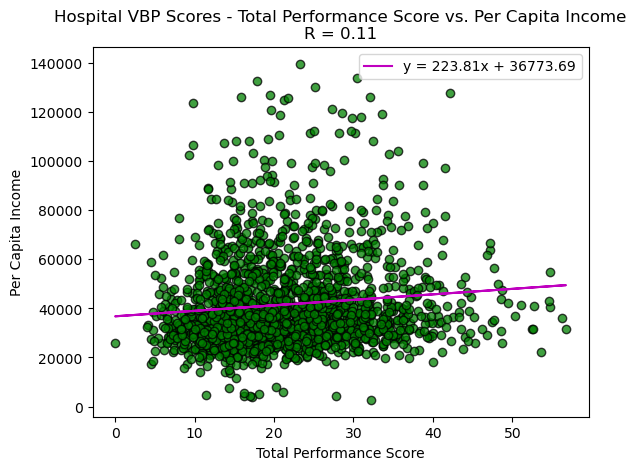

In [42]:
plot_linear_regression(hospital_census_df['Total Performance Score'], hospital_census_df['Per Capita Income'], 
                       'Total Performance Score', 
                       'Per Capita Income', 
                       'Hospital VBP Scores - Total Performance Score vs. Per Capita Income', (10, 270))
plt.show()

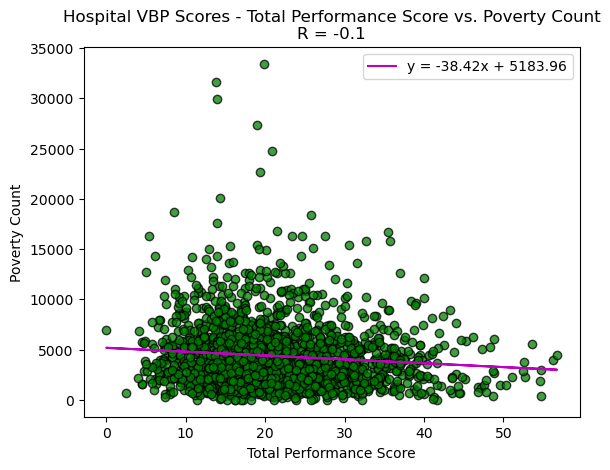

In [43]:
plot_linear_regression(hospital_census_df['Total Performance Score'], hospital_census_df['Poverty Count'], 
                       'Total Performance Score', 
                       'Poverty Count', 
                       'Hospital VBP Scores - Total Performance Score vs. Poverty Count', (10, 270))
plt.show()

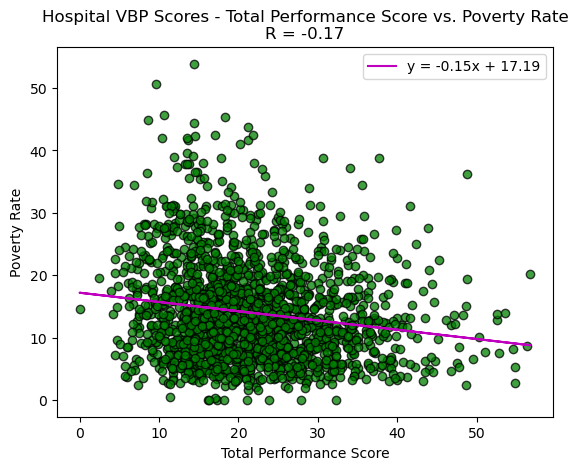

In [44]:
plot_linear_regression(hospital_census_df['Total Performance Score'], hospital_census_df['Poverty Rate'], 
                       'Total Performance Score', 
                       'Poverty Rate', 
                       'Hospital VBP Scores - Total Performance Score vs. Poverty Rate', (10, 270))
plt.show()

### Result for Question #6: There is a slightly negative relationship between Poverty Count and Total Performance Score and Poverty Rate and Total Performance Score.  There is a slight postitive relationship between Per Capita Income and Total Performance Score.  There are areas of the country that are less populated and may also have less income that did not have hospitals included in VBP program.  We used zip codes as reference for poulation which might not show the full picture because people from multiple zip codes may use a singular hospital.   